# **Introduction**

This is a classification dataset where the goal is to predict whether patients have heart disease or not. I imagine this would be used to pre-screen patients for heart disease based on generic characteristics, and those that are predicted positive would then be asked to do more thorough testing.

**The primary focus of my model is to minimize false negatives (and thus maximize the recall score)**. This is because of the "real-world" implications of this scenario. Missing a true-positive would mean the patient wouldn't be flagged for more testing and could potentially go on for years without realizing they have heart disease! Whereas a false-positive would just lead to additional testing for someone who doesn't need it. This approach is common in medical and fraud detection scenarios, where overlooking potential positive instances (false negatives) can lead to critical consequences.

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay

In [361]:
!pip install pyreadstat

# **Data cleaning and preprocessing**

In [362]:
df_fhs = pd.read_csv("framingham.csv")

In [363]:
df_fhs.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [364]:
df_fhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [365]:
df_fhs = df_fhs.drop(['education'], axis=1)
print(df_fhs.columns)

Index(['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')


In [366]:
# finding the pecentage of missing values in each col
df_fhs.isnull().sum()/len(df_fhs)*100

male               0.000000
age                0.000000
currentSmoker      0.000000
cigsPerDay         0.683962
BPMeds             1.250000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179245
sysBP              0.000000
diaBP              0.000000
BMI                0.448113
heartRate          0.023585
glucose            9.150943
TenYearCHD         0.000000
dtype: float64

In [367]:
# replace missing value with mean
df_fhs['cigsPerDay']=df_fhs['cigsPerDay'].fillna(df_fhs['cigsPerDay'].mean())
df_fhs['BPMeds']=df_fhs['BPMeds'].fillna(df_fhs['BPMeds'].mean())
df_fhs['totChol']=df_fhs['totChol'].fillna(df_fhs['totChol'].mean())
df_fhs['glucose']=df_fhs['glucose'].fillna(df_fhs['glucose'].mean())
df_fhs['BMI']=df_fhs['BMI'].fillna(df_fhs['BMI'].mean())

In [368]:
(df_fhs.isnull().sum())*100/len(df_fhs)

male               0.000000
age                0.000000
currentSmoker      0.000000
cigsPerDay         0.000000
BPMeds             0.000000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.000000
sysBP              0.000000
diaBP              0.000000
BMI                0.000000
heartRate          0.023585
glucose            0.000000
TenYearCHD         0.000000
dtype: float64

In [369]:
df_fhs = df_fhs.dropna()

In [370]:
(df_fhs.isnull().sum())*100/len(df_fhs)

male               0.0
age                0.0
currentSmoker      0.0
cigsPerDay         0.0
BPMeds             0.0
prevalentStroke    0.0
prevalentHyp       0.0
diabetes           0.0
totChol            0.0
sysBP              0.0
diaBP              0.0
BMI                0.0
heartRate          0.0
glucose            0.0
TenYearCHD         0.0
dtype: float64

In [371]:
X=df_fhs.iloc[:,:-1].values
y=df_fhs.iloc[:,-1].values

In [372]:
# check for row duplicates
df_fhs.duplicated().sum()

0

# **`EDA`**

In [373]:
df_fhs = df_fhs.rename(columns={'TenYearCHD':'CHD'})

In [374]:
df_fhs['CHD'].value_counts(normalize=True)

0    0.848313
1    0.151687
Name: CHD, dtype: float64

<Axes: >

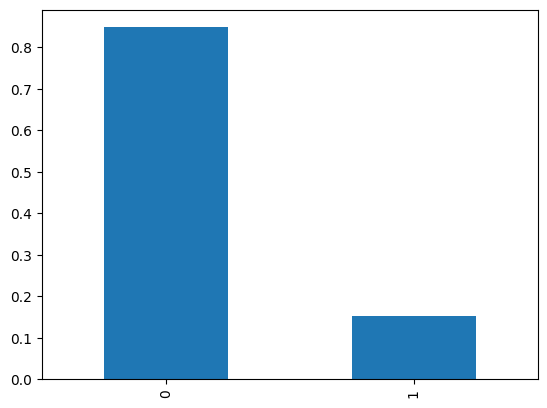

In [375]:
df_fhs['CHD'].value_counts(normalize=True).plot(kind='bar')

In [376]:
df_fhs['sex_cat'] = df_fhs['male'].replace([0, 1],['female','male'])

In [377]:
df_fhs.groupby('sex_cat')['CHD'].mean()

sex_cat
female    0.124380
male      0.188015
Name: CHD, dtype: float64

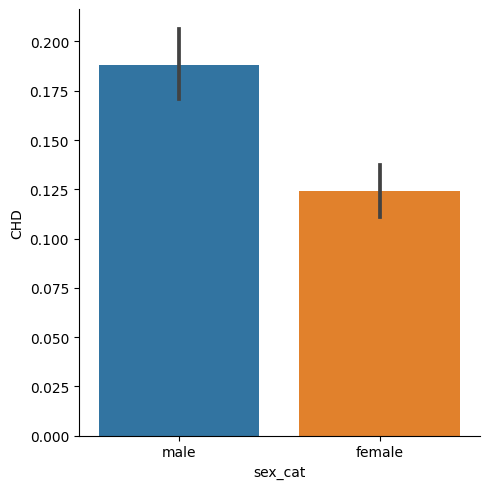

In [378]:
sns.catplot(data=df_fhs, y='CHD', x= 'sex_cat', kind='bar')

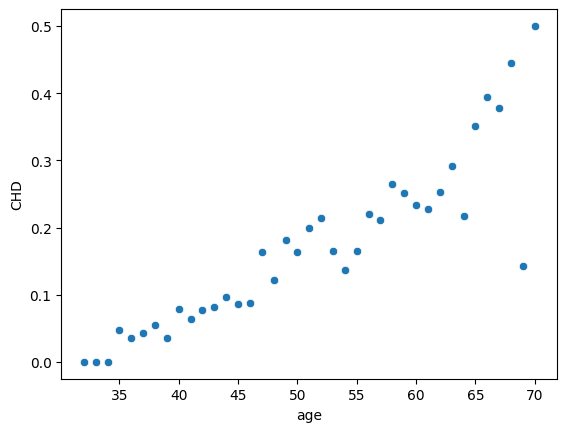

In [379]:
# age vs CHD
age_chd_mean = df_fhs.groupby('age')['CHD'].mean().reset_index()
plt.figure(facecolor='white')
sns.scatterplot(data=age_chd_mean, x='age', y='CHD')
plt.show()

<Axes: xlabel='totChol', ylabel='sysBP'>

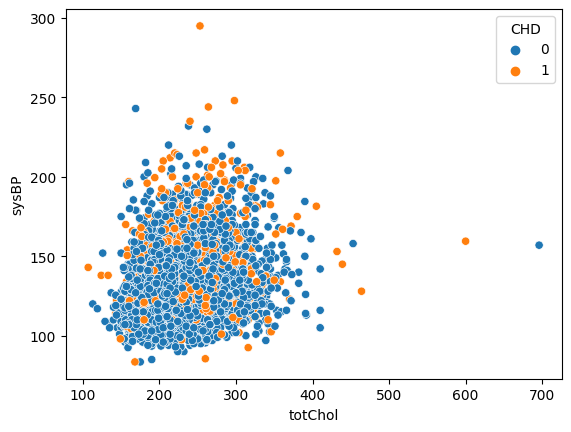

In [380]:
sns.scatterplot(data=df_fhs, y='sysBP', x= 'totChol', hue='CHD')

<Axes: xlabel='totChol', ylabel='sysBP'>

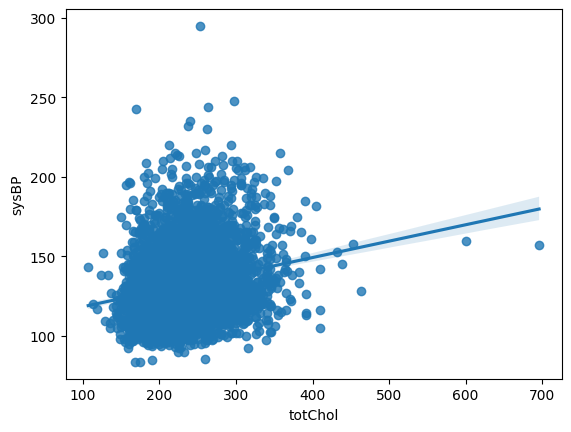

In [381]:
sns.regplot(data=df_fhs, y='sysBP', x= 'totChol')

In [382]:
df_fhs = df_fhs.rename(columns={'male':'sex'})

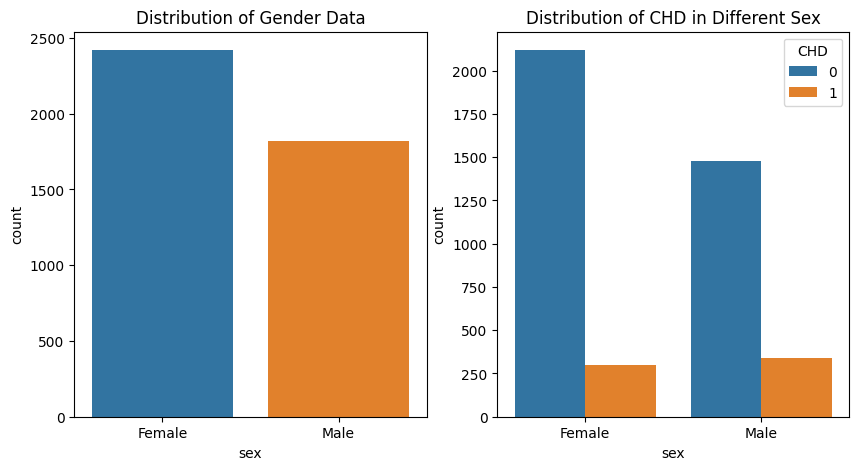

In [383]:
# gender vs CHD
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='sex', data=df_fhs, ax=ax[0])
sns.countplot(x='sex', hue='CHD', data=df_fhs, ax=ax[1])
ax[0].set_title('Distribution of Gender Data')
ax[0].set_xticklabels(['Female', 'Male'])
ax[1].set_title('Distribution of CHD in Different Sex')
ax[1].set_xticklabels(['Female', 'Male'])
plt.show()

In [384]:
df_fhs.nunique().sort_values()
bins = [30, 40, 50, 60, 70, 80]
labels = ['30-39', '40-49', '50-59', '60-69', '70+']
df_fhs['AgeGroup'] = pd.cut(df_fhs['age'], bins=bins, labels=labels, right=False)

In [385]:
col_int = df_fhs.nunique().reset_index()
col_int

,index,0
0,sex,2
1,age,39
2,currentSmoker,2
3,cigsPerDay,34
4,BPMeds,3
5,prevalentStroke,2
6,prevalentHyp,2
7,diabetes,2
8,totChol,249
9,sysBP,234


In [386]:
col_int.columns=['features', 'categories']
col_int['categories'] =col_int['categories'].astype('int64')

In [387]:
col_int = col_int.sort_values(by='categories')
col_int = col_int[col_int.categories<10]

In [388]:
fhs_cat =df_fhs[col_int.features.values]

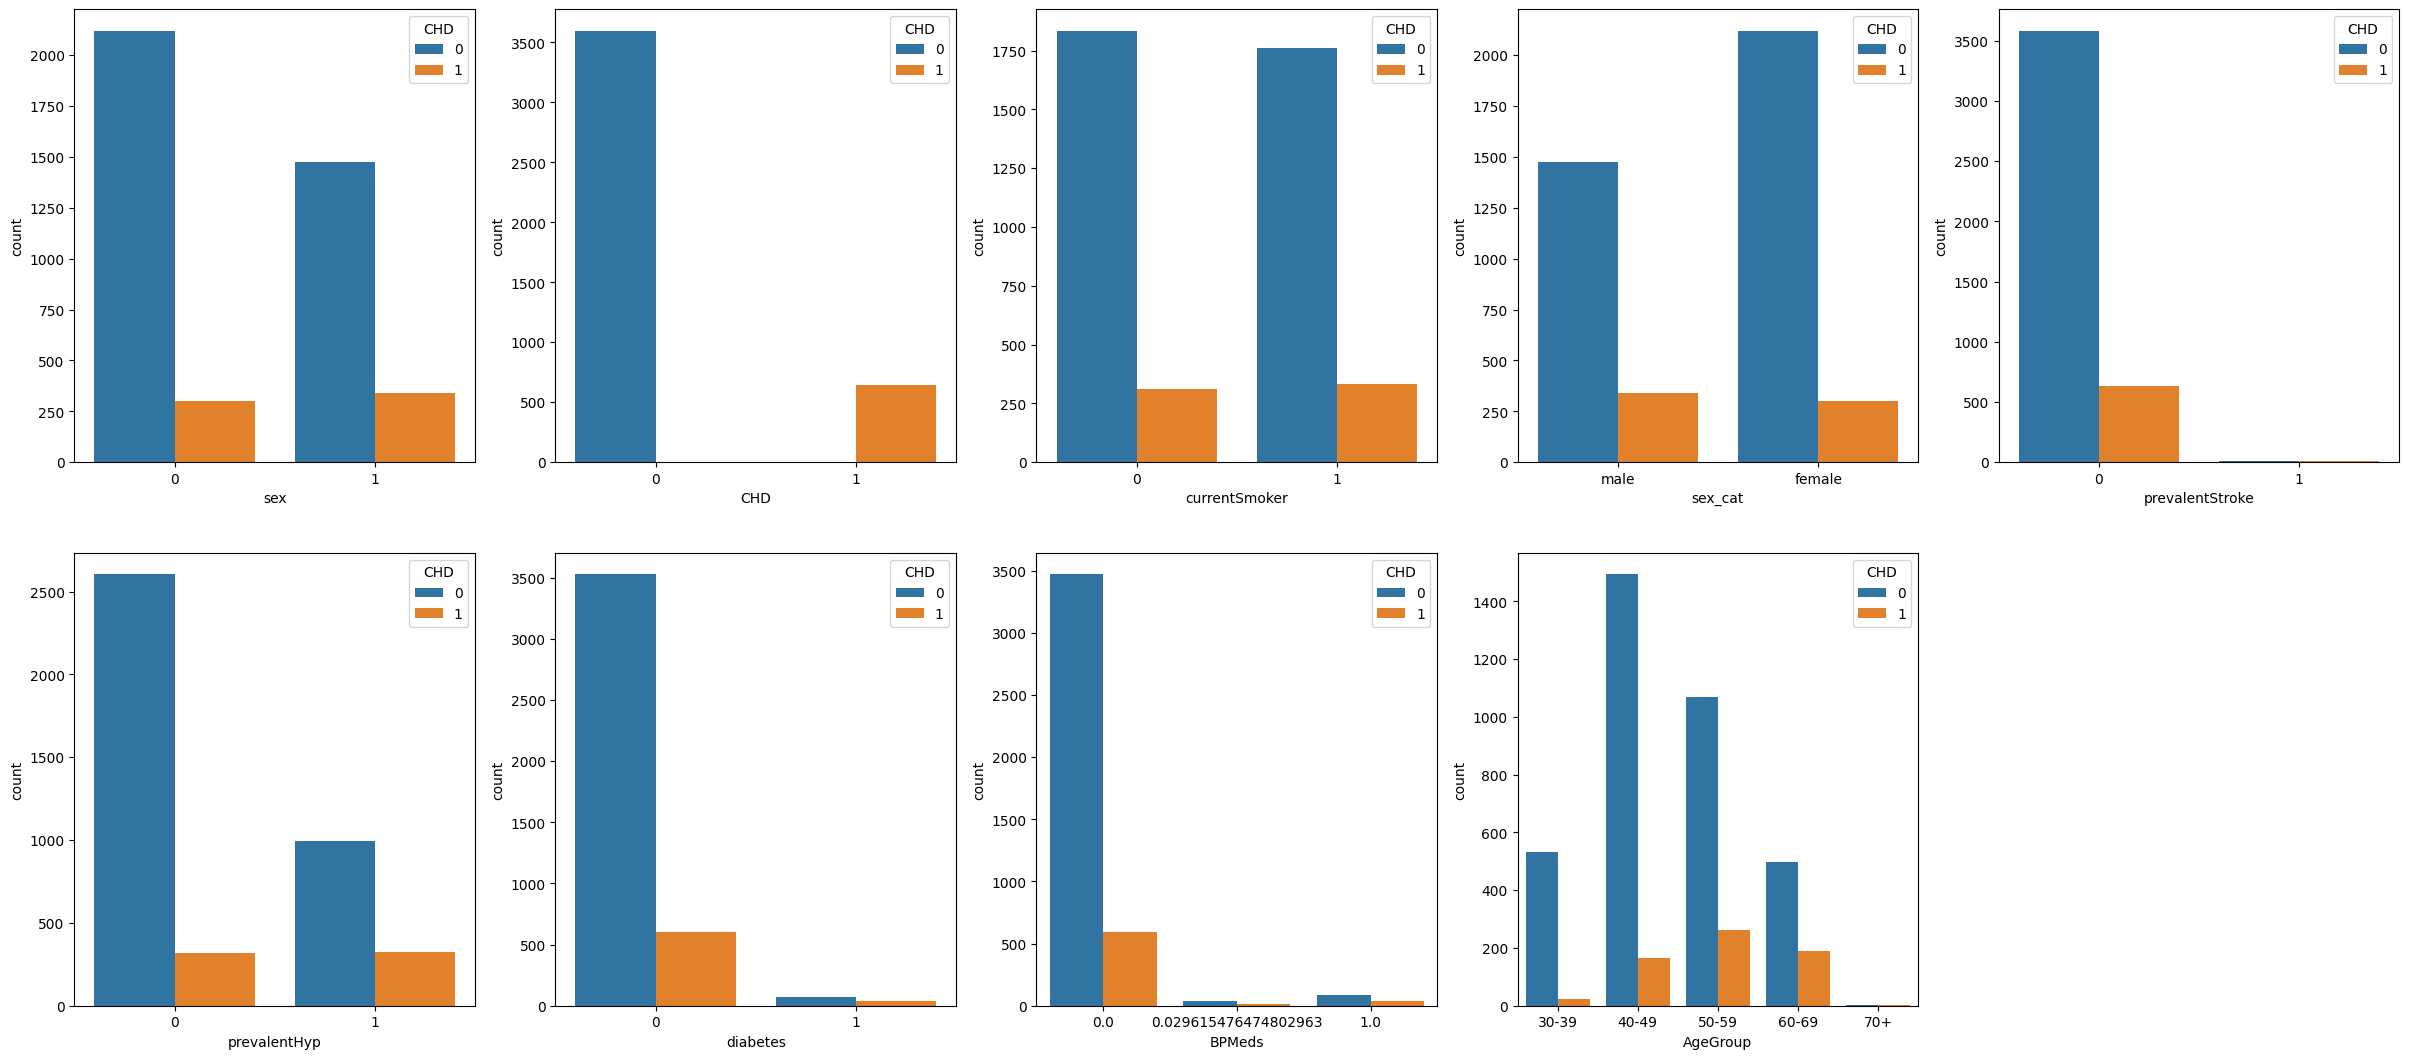

In [389]:
plt.figure(figsize=(30,20))
for i in enumerate(fhs_cat.columns):
  plt.subplot(3, 5, i[0]+1)
  sns.countplot(x=i[1], hue='CHD', data=fhs_cat)

In [390]:
# filter out a subset
fhs_cont = df_fhs.select_dtypes(include=['float'])
fhs_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4239 entries, 0 to 4239
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cigsPerDay  4239 non-null   float64
 1   BPMeds      4239 non-null   float64
 2   totChol     4239 non-null   float64
 3   sysBP       4239 non-null   float64
 4   diaBP       4239 non-null   float64
 5   BMI         4239 non-null   float64
 6   heartRate   4239 non-null   float64
 7   glucose     4239 non-null   float64
dtypes: float64(8)
memory usage: 298.1 KB


<Axes: >

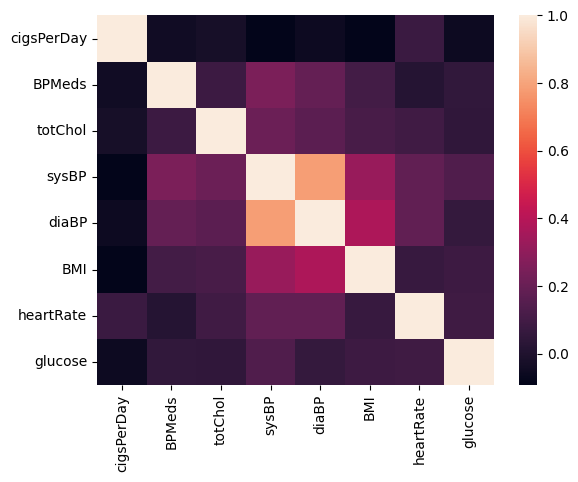

In [391]:
sns.heatmap(fhs_cont.corr())

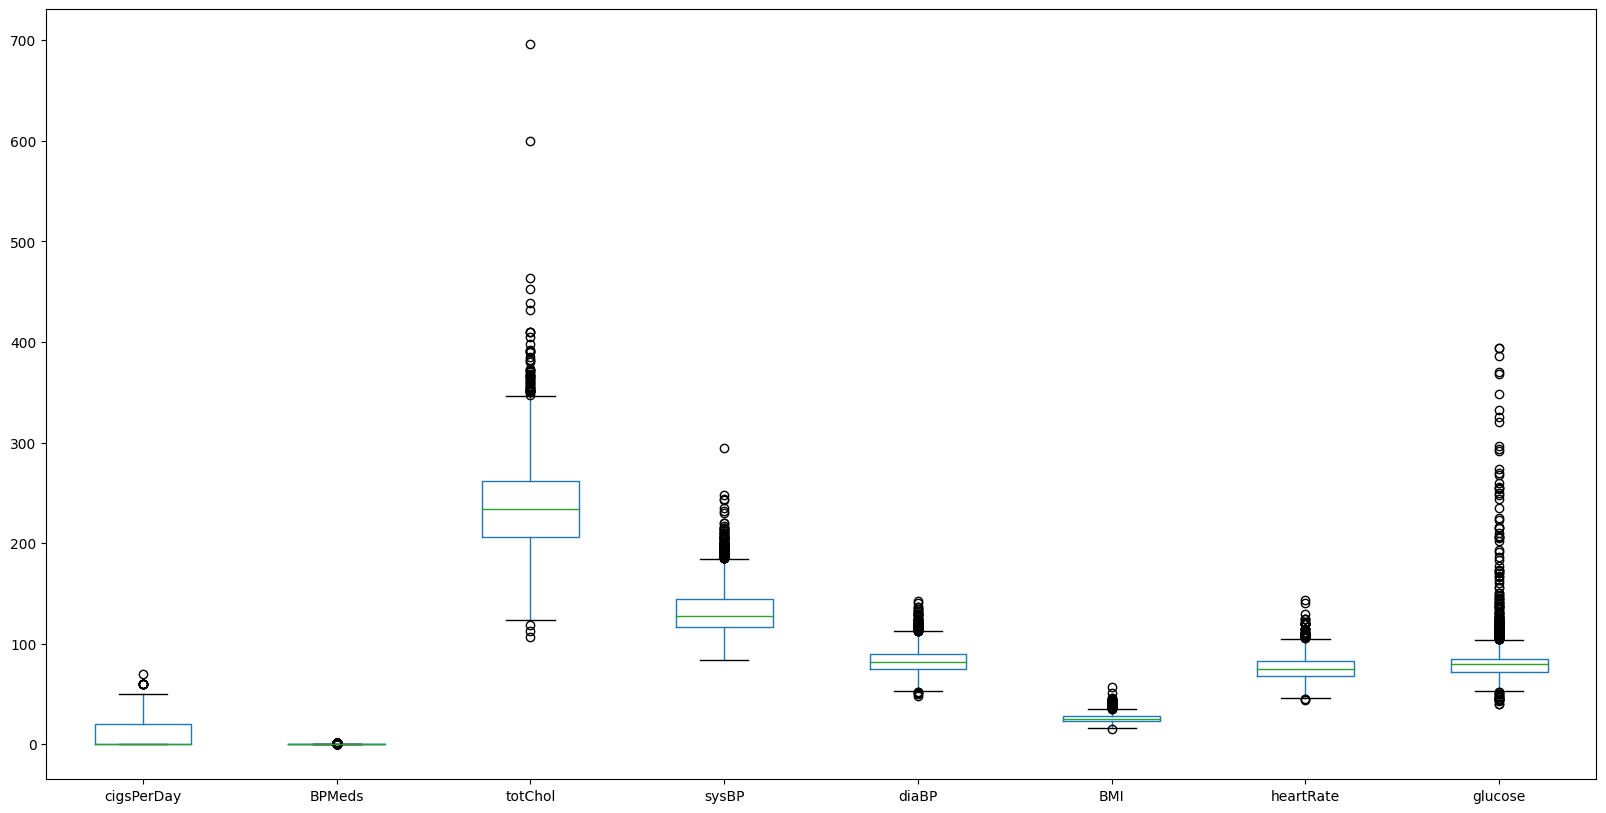

In [392]:
plt.figure(figsize=(20,10))
fhs_cont.boxplot(grid=False)
plt.show()

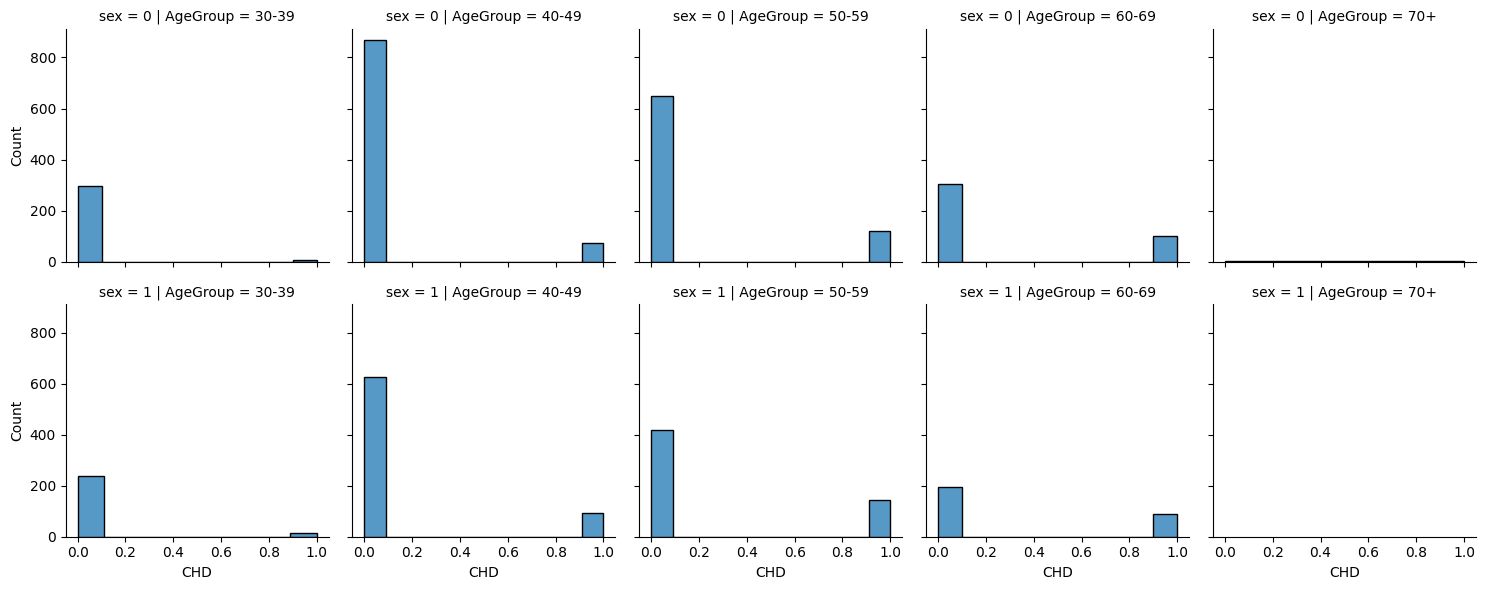

In [393]:
g =sns.FacetGrid(df_fhs,row='sex', col='AgeGroup')
g.map(sns.histplot, 'CHD')
plt.show()


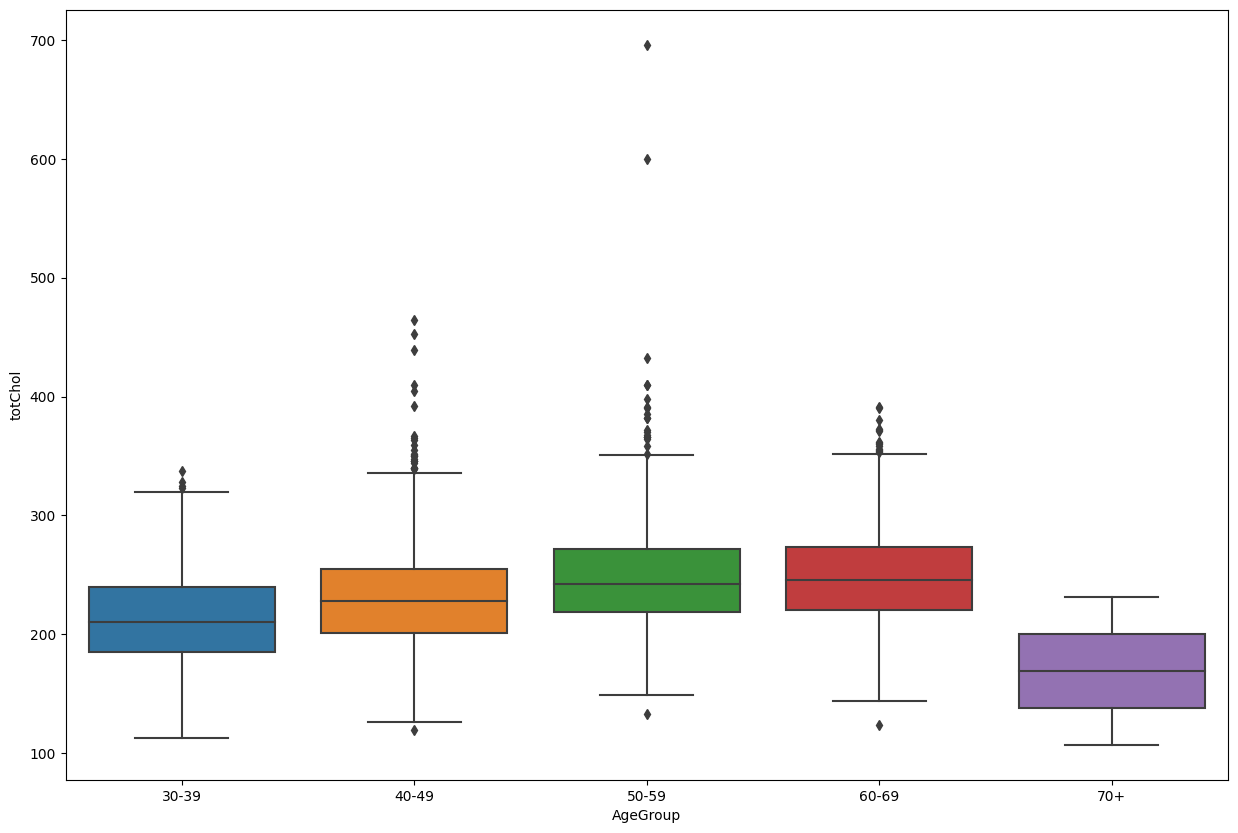

In [394]:
fig, ax =plt.subplots(figsize=(15,10))
sns.boxplot(data=df_fhs, x="AgeGroup", y="totChol", ax=ax)
plt.show()

In [395]:
# target variable distribution
df_fhs['CHD'].value_counts(normalize=True)

0    0.848313
1    0.151687
Name: CHD, dtype: float64

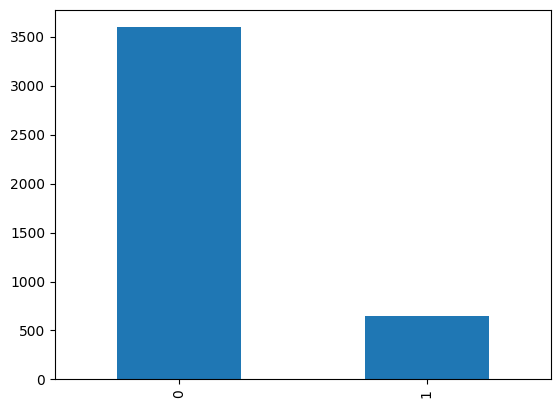

In [396]:
# visualize the distribution in target variable
df_fhs['CHD'].value_counts().plot(kind='bar')
plt.show()

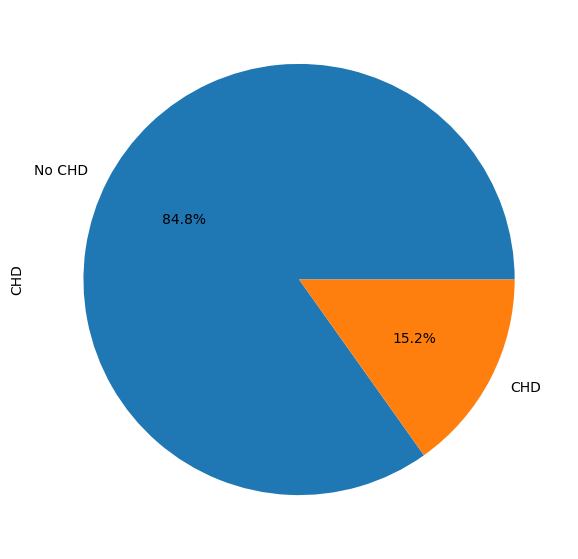

In [397]:
plt.figure(figsize=(10,7))
df_fhs['CHD'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['No CHD', 'CHD'])
plt.show()

<ipython-input-398-cbcee1639682>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_fhs.corr())


<Axes: >

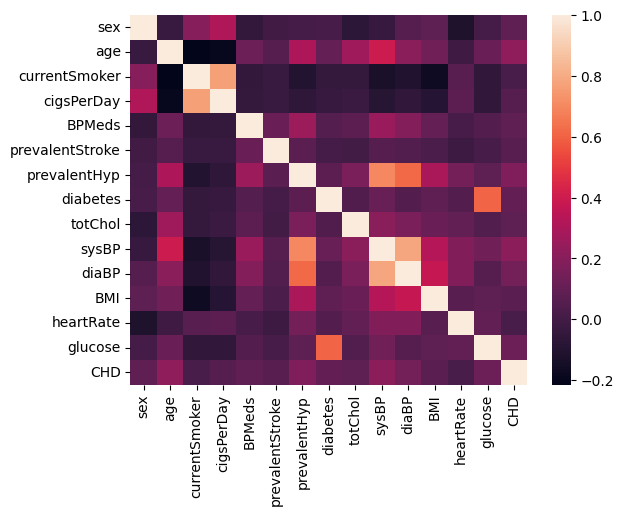

In [398]:
sns.heatmap(df_fhs.corr())

# **Training and Testing**

In [399]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

# Scaling the features for optimal model performance
sc_train = StandardScaler().fit(x_train)
x_train_sc = sc_train.transform(x_train)

# Apply SMOTE to the training data only
os = SMOTE(random_state=0)
x_train_os, y_train_os = os.fit_resample(x_train_sc, y_train)

x_test_sc = sc_train.transform(x_test)



		LogisticRegression model
[[1067    9]
 [ 184   12]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1076
           1       0.57      0.06      0.11       196

    accuracy                           0.85      1272
   macro avg       0.71      0.53      0.51      1272
weighted avg       0.81      0.85      0.79      1272



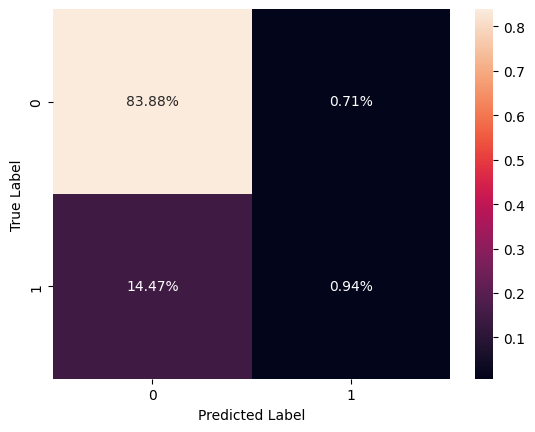

In [400]:
# LogisticRegression model
lr_1 = LogisticRegression(solver='liblinear')
lr_1.fit(x_train_sc, y_train)
print("\n\t\tLogisticRegression model")
pred_y =lr_1.predict(x_test_sc)

# Confusion matrix and classification report
matrix =confusion_matrix(y_test,pred_y)
print(matrix)
s =sns.heatmap(matrix/np.sum(matrix), fmt='.2%', annot=True)
s.set(xlabel='Predicted Label', ylabel='True Label')
report = classification_report(y_test, pred_y)
print(report)

In [401]:
# test the performance of the model on the test data
res = lr_1.score(x_test_sc, y_test)
print("Test score of the Logistic Regression model: " + str(res*100))

# test the performance of the model on the train data
res = lr_1.score(x_train_sc, y_train)
print("Training score of the Logistic Regression model: " + str(res*100))

Test score of the Logistic Regression model: 84.82704402515722
Training score of the Logistic Regression model: 85.77687900235928



		RandomForestClassifier model
[[1028   48]
 [ 172   24]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1076
           1       0.33      0.12      0.18       196

    accuracy                           0.83      1272
   macro avg       0.59      0.54      0.54      1272
weighted avg       0.78      0.83      0.79      1272



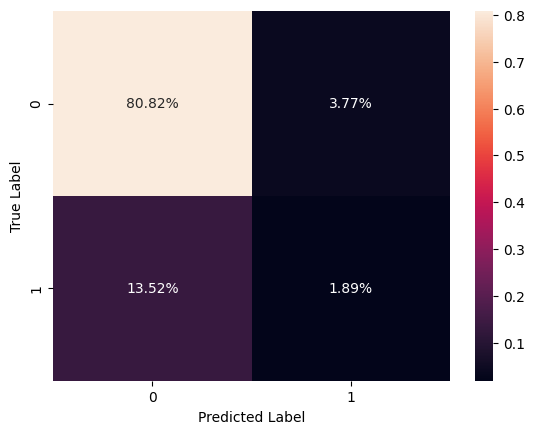

In [402]:
# RandomForestClassifier model

classifier1 = RandomForestClassifier(n_estimators = 5, random_state = 0, max_depth=20)
classifier1.fit(x_train_sc, y_train)
y_pred_train = classifier1.predict(x_train_sc)
print("\n\t\tRandomForestClassifier model")
y_pred = classifier1.predict(x_test_sc)

# Confusion matrix and classification report
matrix= confusion_matrix(y_test,y_pred)
print(matrix)
s = sns.heatmap(matrix/np.sum(matrix), fmt='.2%', annot=True)
s.set(xlabel='Predicted Label', ylabel='True Label')
report = classification_report(y_test, y_pred)
print(report)

In [403]:
# test the performance of the model on the test data
res = classifier1.score(x_test_sc, y_test)
print("Test score of RandomForestClassifier model: " + str(res*100))
# test the performance of the model on the train data
res = classifier1.score(x_train_sc, y_train)
print("Training score of RandomForestClassifier model: " + str(res*100))

Test score of RandomForestClassifier model: 82.70440251572327
Training score of RandomForestClassifier model: 96.96663296258848



		DecisionTreeClassifier model
[[1017   59]
 [ 177   19]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1076
           1       0.24      0.10      0.14       196

    accuracy                           0.81      1272
   macro avg       0.55      0.52      0.52      1272
weighted avg       0.76      0.81      0.78      1272



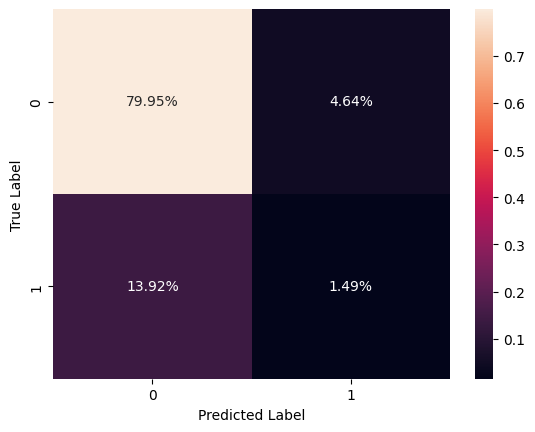

In [404]:
# DecisionTreeClassifier model
classifier2 = DecisionTreeClassifier(max_depth=10, random_state=0)
classifier2.fit(x_train_sc, y_train)
y_pred_train_dt = classifier2.predict(x_train_sc)
y_pred_dt = classifier2.predict(x_test_sc)

# Confusion matrix and classification report
matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("\n\t\tDecisionTreeClassifier model")
print(matrix_dt)
s_dt = sns.heatmap(matrix_dt / np.sum(matrix_dt), fmt='.2%', annot=True)
s_dt.set(xlabel='Predicted Label', ylabel='True Label')
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)


In [405]:
# test the performance of the model on the test data
res = classifier2.score(x_test_sc, y_test)
print("Test score of RandomForestClassifier model: " + str(res*100))
# test the performance of the model on the train data
res = classifier2.score(x_train_sc, y_train)
print("Training score of RandomForestClassifier model: " + str(res*100))

Test score of RandomForestClassifier model: 81.44654088050315
Training score of RandomForestClassifier model: 91.47286821705426


Fitting 5 folds for each of 30 candidates, totalling 150 fits

		LogisticRegression with grid search
[[1068    8]
 [ 185   11]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1076
           1       0.58      0.06      0.10       196

    accuracy                           0.85      1272
   macro avg       0.72      0.52      0.51      1272
weighted avg       0.81      0.85      0.79      1272



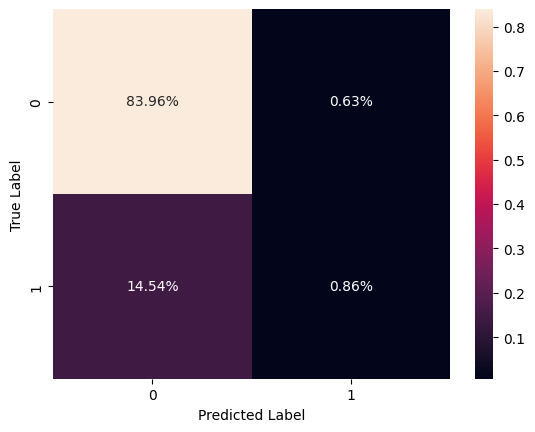

In [406]:
# LogisticRegression model with grid search
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr = LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_sc, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_lr_model = grid_search.best_estimator_
pred_y_best = best_lr_model.predict(x_test_sc)

# Confusion matrix and classification report
matrix_best = confusion_matrix(y_test, pred_y_best)
print("\n\t\tLogisticRegression with grid search")
print(matrix_best)
s_best = sns.heatmap(matrix_best / np.sum(matrix_best), fmt='.2%', annot=True)
s_best.set(xlabel='Predicted Label', ylabel='True Label')

report_best = classification_report(y_test, pred_y_best)
print(report_best)


In [407]:
# test score of the Logistic Regression model with grid search
res = best_lr_model.score(x_test_sc, y_test)
print("Test score of the Logistic Regression model with grid search: " + str(res*100))

# training score of the Logistic Regression model with grid search
res = best_lr_model.score(x_train_sc, y_train)
print("Training score of the Logistic Regression model with grid search: " + str(res*100))


Test score of the Logistic Regression model with grid search: 84.82704402515722
Training score of the Logistic Regression model with grid search: 85.70947084597236


Employing Grid Search to enhance the model's predictive accuracy and generalization by tuning hyperparameters within Logistic Regression does not demonstrate significant improvements over the basic Logistic Regression approach.

All models have terrible recall scores. To address this limitation, I have implemented a two-stage model. This approach aims to significantly reduce false negatives by leveraging a blend of classifiers, thereby enhancing accuracy and generalization.

# **Two Stage Model:**
 I used a Logistic Regression as the primary classifier, followed by an XGBoost Classifier in a secondary stage which is only applied to cases where the primary model predicted "No heart disease". This tailors the model to enhance the identification of potential false negatives. Minimizing false-negative predictions of heart disease is critical, as errors in diagnosis could potentially have life-threatening consequences.

Best Parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
[[1076    0]
 [   0  196]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1076
           1       1.00      1.00      1.00       196

    accuracy                           1.00      1272
   macro avg       1.00      1.00      1.00      1272
weighted avg       1.00      1.00      1.00      1272



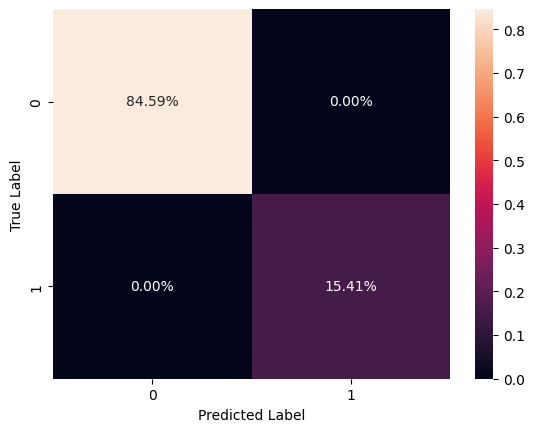

In [408]:
# Stage 1: Logistic Regression
classifier1 = LogisticRegression(solver='newton-cg')

# Train the Logistic Regression model
classifier1.fit(x_train_sc, y_train)

# Predict probabilities for class 0 (assuming binary classification)
probabilities_stage1 = classifier1.predict_proba(x_train_sc)[:, 0]

# Identify instances labeled as 0
indices_stage2 = np.where(y_train == 0)[0]

# Prepare data for the second stage
x_train_stage2 = x_train_sc[indices_stage2]
y_train_stage2 = y_train[indices_stage2]
probabilities_stage2 = probabilities_stage1[indices_stage2]

# Stage 2: XGBoost Classifier
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Instantiate GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=0), param_grid_xgb, cv=5, scoring='accuracy')

# Fit GridSearchCV to the data for the second stage
grid_search_xgb.fit(x_train_stage2, y_train_stage2)

# Get the best parameters for XGBoost
best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

# Use the best model from GridSearchCV for the second stage
best_xgb_classifier = grid_search_xgb.best_estimator_

# Predict on the test set using both stages
probabilities_test_stage1 = classifier1.predict_proba(x_test_sc)[:, 0]
indices_test_stage2 = np.where(y_test == 0)[0]
x_test_stage2 = x_test_sc[indices_test_stage2]

# Predict using the XGBoost model on instances labeled as 0
y_pred_stage2 = best_xgb_classifier.predict(x_test_stage2)

# Combine predictions for the two stages
y_pred = y_test.copy()
y_pred[indices_test_stage2] = y_pred_stage2


# Calculate predictions for the training set using the two-stage model
indices_train_stage2 = np.where(y_train == 0)[0]
x_train_stage2 = x_train_sc[indices_train_stage2]

# Predict using the XGBoost model on instances labeled as 0 in the training set
y_pred_train_stage2 = best_xgb_classifier.predict(x_train_stage2)

# Combine predictions for the two stages in the training set
y_pred_train = y_train.copy()
y_pred_train[indices_train_stage2] = y_pred_train_stage2


# Evaluate the combined predictions
matrix = confusion_matrix(y_test, y_pred)
print(matrix)
s = sns.heatmap(matrix/np.sum(matrix), fmt='.2%', annot=True)
s.set(xlabel='Predicted Label', ylabel='True Label')

report = classification_report(y_test, y_pred)
print(report)


In [409]:
# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy of the two-stage model:", test_accuracy * 100)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy of the two-stage model:", train_accuracy * 100)

Test Accuracy of the two-stage model: 100.0
Training Accuracy of the two-stage model: 100.0


In [410]:
# lsit of feautures
exclude_columns = ['CHD', 'sex_cat', 'AgeGroup']
features = [col for col in df_fhs.columns if col not in exclude_columns]


In [411]:
coefficients = classifier1.coef_[0]
coefficients = coefficients.ravel().tolist()

In [412]:
# table of the coefficient and features name
data = {'Features':features,
        'coefficients':coefficients}
coeff_table = pd.DataFrame(data)
coeff_table = coeff_table.sort_values(by='coefficients')

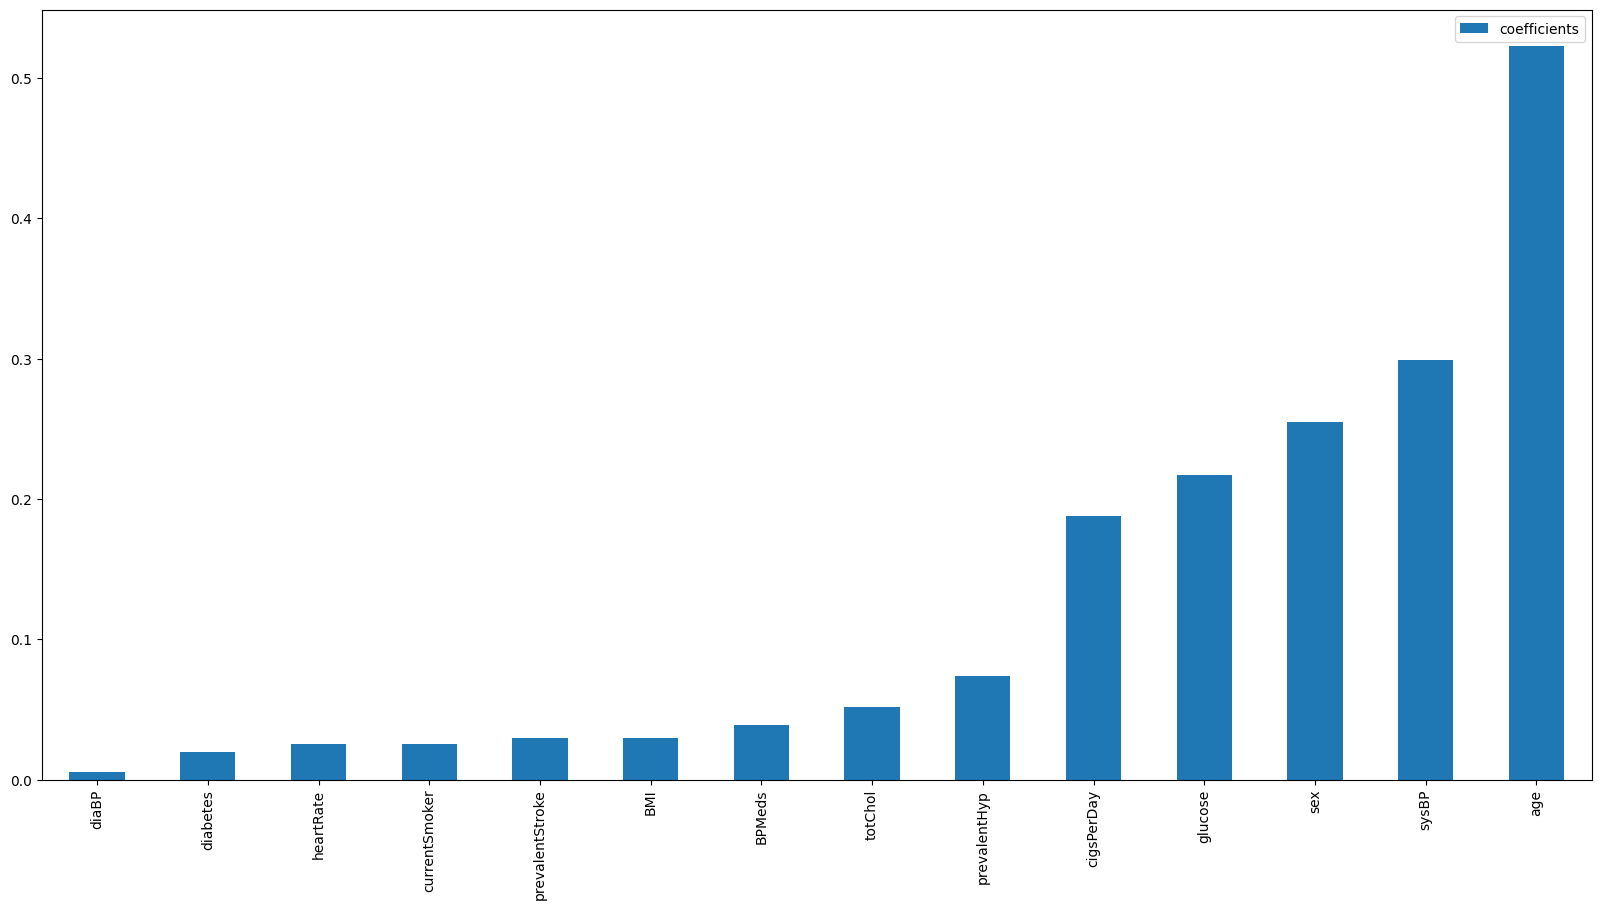

In [413]:
coeff_table.plot(kind='bar', figsize=(20,10))
plt.xticks(np.arange(0,14),coeff_table['Features'])
plt.show()

Age emerged as the most influential factor, exhibiting a strong positive correlation. This finding suggests that as individuals grow older, the likelihood of developing heart disease increases substantially. Systolic blood pressure (sysBP), CigsPerDay and sex also demonstrated notable correlations, indicating their influence on heart disease, although to a lesser extent compared to age. Moreover, glucose level showed a slightly stronger correlation than other factors considered, such as prevalentStroke and prevalentHyp, which exhibited a comparatively weaker association with heart disease. Intriguingly, while the variable 'current smoker' did not directly impact the chances of heart disease, an increase in the number of cigarettes smoked per day seemed to elevate the likelihood of heart disease, hinting at a potential link between smoking intensity and the risk of cardiovascular issues.

# **Cross Validation**

In [414]:
# cross validation for two stage model

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scores = []

for train_index, test_index in skf.split(x_train_os, y_train_os):
    # Split the data
    x_train_fold, x_test_fold = x_train_os[train_index], x_train_os[test_index]
    y_train_fold, y_test_fold = y_train_os[train_index], y_train_os[test_index]


    # First Stage: Train Logistic Regression
    classifier1.fit(x_train_fold, y_train_fold)

    # Predict probabilities for class 0
    probabilities_stage1 = classifier1.predict_proba(x_train_fold)[:, 0]

    # Identify instances labeled as 0
    indices_stage2 = np.where(y_train_fold == 0)[0]

    # Prepare data for the second stage
    indices_stage2 = np.where(y_train_fold == 0)[0]
    x_train_stage2 = x_train_fold[indices_stage2]
    y_train_stage2 = y_train_fold[indices_stage2]
    probabilities_stage2 = probabilities_stage1[indices_stage2]


    # Second Stage: Train XGBoost
    best_xgb_classifier.fit(x_train_stage2, y_train_stage2)

    # Predict on the test set using both stages
    probabilities_test_stage1 = classifier1.predict_proba(x_test_fold)[:, 0]
    indices_test_stage2 = np.where(y_test_fold == 0)[0]
    x_test_stage2 = x_test_fold[indices_test_stage2]

    # Predict using the XGBoost model on instances labeled as 0
    y_pred_stage2 = best_xgb_classifier.predict(x_test_stage2)

    # Combine predictions for the two stages
    y_pred = y_test_fold.copy()
    y_pred[indices_test_stage2] = y_pred_stage2

    accuracy = accuracy_score(y_test_fold, y_pred)
    scores.append(accuracy)


print("Cross Validation scores for the Two Stage Model:", scores)
print("Mean Cross Validation Score of Two Stage Model:", np.mean(scores) * 100)


Cross Validation scores for the Two Stage Model: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean Cross Validation Score of Two Stage Model: 100.0


In [415]:
# cross validation for LogisticRegression model
cv_scores = cross_val_score(lr_1, x_train_sc, y_train, cv=5)
print("\nCross Validation Scores for the LogisticRegression Model:", cv_scores)
print(f"Mean Cross Validation Score of LogisticRegression Model: {np.mean(cv_scores*100):.4f}")


Cross Validation Scores for the LogisticRegression Model: [0.85521886 0.85016835 0.8549747  0.84991568 0.86340641]
Mean Cross Validation Score of LogisticRegression Model: 85.4737


In [416]:
# cross validation for LogisticRegression model with grid search
cv_scores = cross_val_score(best_lr_model, x_train_sc, y_train, cv=5)
print("Cross Validation Scores for the LogisticRegression Model with Grid Search:", cv_scores)
print(f"Mean Cross Validation Score of LogisticRegression Model with Grid Search: {np.mean(cv_scores*100):.4f}")

Cross Validation Scores for the LogisticRegression Model with Grid Search: [0.85521886 0.85185185 0.85666105 0.84991568 0.86340641]
Mean Cross Validation Score of LogisticRegression Model with Grid Search: 85.5411


In [417]:
# cross validation for RandomForestClassifier model
cv_scores = cross_val_score(classifier1, x_train_sc, y_train, cv=5)
print("\nCross Validation Scores for the RandomForestClassifier Model:", cv_scores)
print(f"Mean Cross Validation Score of RandomForestClassifier Model: {np.mean(cv_scores*100):.4f}")


Cross Validation Scores for the RandomForestClassifier Model: [0.85521886 0.85016835 0.8549747  0.84991568 0.86340641]
Mean Cross Validation Score of RandomForestClassifier Model: 85.4737


In [418]:
# cross validation for DecisionTreeClassifier model
cv_scores = cross_val_score(classifier2, x_train_sc, y_train, cv=5)
print("\nCross Validation Scores for the DecisionTreeClassifier Model:", cv_scores)
print(f"Mean Cross Validation Score of DecisionTreeClassifier model: {np.mean(cv_scores*100):.4f}")


Cross Validation Scores for the DecisionTreeClassifier Model: [0.80976431 0.79292929 0.81112985 0.79932546 0.82124789]
Mean Cross Validation Score of DecisionTreeClassifier model: 80.6879
